# Neural language models for text generation
<b>Objective</b><br>
The ability to generate text that resembles the quality of human language has numerous applications, from machine translation to spelling correction, from text summarization to image captioning. At the heart of these larger tasks is the language model, which is a function or algorithm for learning that function that captures relevant statistical characteristics of the distribution of sequences of words in a natural language (Bengio, 2008). This study is an examination of the neural language model, specifically, as a foundation for larger NLP tasks and a representative step in the evolution beyond traditional statistical modeling. Its goal is two-fold: develop neural language models for capturing the “essence” of a large corpora of text and gain an in-depth understanding of how various factors affect fitting and ultimate performance with networks with differing deep learning architectures. This will shed light on how hidden nodes learn to extract features from inputs; with additional layers, the objective is to better understand how each successive layer extracts progressively abstract and generalized features. This is done through the development, evaluation, and comparison of word-based neural language models for text generation.<br>

<b>Data source for model development and evaluation</b><br>
Data for this study comes from __[Project Gutenberg](https://www.gutenberg.org)__, a repository of over 60,000 publicly-available books, with focus on older works for which U.S. copyright has expired. Beyond a source of great literature free and open to everyone, the text versions of these works offer countless opportunities for experimentation with machine learning techniques using unstructured text. Each group of experiments in the study focuses on a particular novel, in this case Franz Kafka's 1915 novel <i>The Metamorphosis</i>. A separate study is conducted as a point of comparison using <i>Alice's Adventures in Wonderland</i>, an 1865 novel written by English author Lewis Carroll.<br>

<b>Model development</b><br>
Using these two separate texts, various network architectures are tested to determine their ability to capture meaning and context from these two texts and generate reliable, believable sequences of related text based on predictions of probability given an input sequence of text. Long Short-Term Memory (LSTM) Recurrent Neural Networks (RNNs) are employed primarily given these networks’ established performance with text generation and ability to help mitigate, in some cases, overfitting and the challenge of vanishing gradients. LSTM RNNs are also the focus due to their potential to retain sequence-based meaning, from words in sentences to sentences in paragraphs; the longer nature of these texts offers a useful data source for testing this possibility. Varying network depth and width are investigated for potential impact on performance, which is ultimately measured quantitatively (via loss and training time) and qualitatively (via generated text examples from seed text and comparison to actual text that follows). While this evaluation is not perfectly objective, these combined steps shed light on how well the various models capture meaning from text, which serves as useful in certain standalone cases and, more importantly, as a critical input to more complex NLP tasks.

<b>Model evaluation</b><br>
Model accuracy, loss, and training time are all measured for evaluation purposes. It is important to mention that the most accurate classification model of the training dataset is not the objective - this would reflect rote memorization of the text, which would reveal nothing meaningful about the neural networks' ability to capture the essence of the text. What is more important is a generalization of the dataset and the minimization of the chosen loss function, categorical cross-entropy. The ultimate goal is a balance between generalization and overfitting, which is difficult to measure. Qualitative evaluation and exploration of multiple examples will serve as proxy metrics for performance. 

## 1. Environment preparation

In [0]:
# Import dependencies
import string
import re
import os
import time
import numpy as np
from numpy import array
import pandas as pd
from collections import Counter
from random import randint
from pickle import load, dump

import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [144]:
# Mount point for Colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [145]:
# Save in Colab
os.getcwd()
%cd /content/gdrive/My\ Drive/MSDS458/A4/meta
!pwd
# !ls
print('Working Directory')
print(os.getcwd())
work_dir = "content/gdrive/My Drive/MSDS458/A4/meta"

/content/gdrive/My Drive/MSDS458/A4/meta
/content/gdrive/My Drive/MSDS458/A4/meta
Working Directory
/content/gdrive/My Drive/MSDS458/A4/meta


In [0]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## 2. Data load, pre-processing, and exploration
Each group of experiments in the study focuses on a particular novel, in this case <i>The Metamorphosis</i>, a 1915 novel written by Czech author Franz Kafka, originally in German and translated to multiple languages. The English translation from David Wyllie is used for this study.  

Pre-processing steps involve the following:
* Loading the text document
* Cleaning the document (lower-casing, removal of punctuation, tokenization)
* Saving a clean copy of the text

Exploratory data analysis is conducted as well:
* Outputting most- and least-frequent tokens (with and without stopwords removed) to explore word frequencies 
* Bigram counts to explore which two-word pairs of words occur frequently. This can help reveal (potentially) more meaningful frequencies than single words simply as they appear on their own in the text.
* Defining a function for lexical diversity and calculating it for the text as is, and also with stopwords removed. Lexical diversity refers to the range of different words used in a text. Its meaning is text-dependent and not a perfect reflection, however it gives an indication of the scope of different kinds of words in the text; a greater range (higher number) may indicate higher diversity. It is the number of unique tokens in a text as a proportion of total tokens, calculated as follows:

$$
\frac{len(set(text)}{len(text)}
$$

In [1]:
# Define function to load document into memory
def load_doc(filename):
    # Open the file as read only
    file = open(filename, 'r')
    # Read all text
    text = file.read()
    # Close the file
    file.close()
    return text

In [6]:
# Load document
in_filename = 'input/meta-clean.txt'
doc = load_doc(in_filename)
print(doc[:400])

One morning, when Gregor Samsa woke from troubled dreams, he found
himself transformed in his bed into a horrible vermin.  He lay on
his armour-like back, and if he lifted his head a little he could
see his brown belly, slightly domed and divided by arches into stiff
sections.  The bedding was hardly able to cover it and seemed ready
to slide off any moment.  His many legs, pitifully thin compared


### 1. Clean text

In [0]:
# Define function for turning document into clean tokens
def clean_doc(doc):
    # replace '--' with a space ' '
    doc = doc.replace('--', ' ')
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # make lower case
    tokens = [word.lower() for word in tokens]
    return tokens

In [8]:
# Clean document and output total and unique values
tokens = clean_doc(doc)
vocab = set(tokens)
print(tokens[:200])
print('---------------------------------------')
print('Total tokens: %d' % len(tokens))
print('--------------------------')
print('Unique tokens: %d' % len(set(tokens)))

['one', 'morning', 'when', 'gregor', 'samsa', 'woke', 'from', 'troubled', 'dreams', 'he', 'found', 'himself', 'transformed', 'in', 'his', 'bed', 'into', 'a', 'horrible', 'vermin', 'he', 'lay', 'on', 'his', 'armourlike', 'back', 'and', 'if', 'he', 'lifted', 'his', 'head', 'a', 'little', 'he', 'could', 'see', 'his', 'brown', 'belly', 'slightly', 'domed', 'and', 'divided', 'by', 'arches', 'into', 'stiff', 'sections', 'the', 'bedding', 'was', 'hardly', 'able', 'to', 'cover', 'it', 'and', 'seemed', 'ready', 'to', 'slide', 'off', 'any', 'moment', 'his', 'many', 'legs', 'pitifully', 'thin', 'compared', 'with', 'the', 'size', 'of', 'the', 'rest', 'of', 'him', 'waved', 'about', 'helplessly', 'as', 'he', 'looked', 'whats', 'happened', 'to', 'me', 'he', 'thought', 'it', 'wasnt', 'a', 'dream', 'his', 'room', 'a', 'proper', 'human', 'room', 'although', 'a', 'little', 'too', 'small', 'lay', 'peacefully', 'between', 'its', 'four', 'familiar', 'walls', 'a', 'collection', 'of', 'textile', 'samples', 'l

### 2. Exploratory data analysis

In [0]:
# Define functions for lexical diversity and percentage of total
def lexical_diversity(text):
    return len(set(text)) / len(text) 

def percentage(count, total):   
    return 100 * count / total

In [10]:
lexical_diversity(tokens)

0.11871876419809177

In [0]:
# Plot word frequency
# Initialize a dictionary
dict = {}

# Count number of times each word comes up in list of words
for key in tokens: 
    dict[key] = dict.get(key, 0) + 1

counts = sorted(dict.items(), key = lambda x: x[1], reverse = True)

In [0]:
# Most and least frequent word occurence
top_counts = counts[:30]
least_counts = counts[-30:]

In [13]:
print('top_counts:', top_counts)
print('--------------------------')
print('least_counts:', least_counts)

top_counts: [('the', 1148), ('to', 753), ('and', 642), ('he', 577), ('his', 550), ('of', 429), ('was', 409), ('it', 352), ('had', 352), ('in', 348), ('that', 333), ('a', 285), ('as', 242), ('gregor', 199), ('with', 199), ('she', 196), ('him', 188), ('her', 187), ('would', 187), ('not', 176), ('but', 171), ('at', 169), ('for', 166), ('they', 156), ('on', 152), ('all', 134), ('room', 131), ('from', 119), ('could', 119), ('be', 119)]
--------------------------
least_counts: [('terribly', 1), ('tonight', 1), ('gets', 1), ('destroyed', 1), ('gained', 1), ('twisted', 1), ('stuff', 1), ('kissed', 1), ('hugged', 1), ('country', 1), ('sunshine', 1), ('comfortably', 1), ('seats', 1), ('discussed', 1), ('examination', 1), ('jobs', 1), ('promise', 1), ('cheaper', 1), ('location', 1), ('practical', 1), ('livelier', 1), ('cheeks', 1), ('pale', 1), ('simultaneously', 1), ('blossoming', 1), ('built', 1), ('quieter', 1), ('agreed', 1), ('confirmation', 1), ('destination', 1)]


**Figure 1: Top 30 most frequently occurring tokens from text**

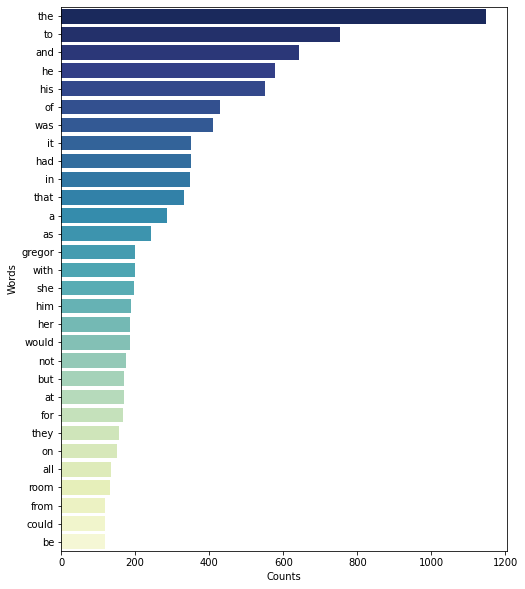

In [14]:
# Plot frequencies
words_plot = pd.DataFrame(top_counts, columns = ['Words', 'Counts'])
plt.figure(figsize=(8,10))
sns.barplot(y="Words", x="Counts", data=words_plot, palette = "YlGnBu_r")

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# Function to create clean doc with stopwords removed
def clean_doc_sw(doc):
    # replace '--' with a space ' '
    doc = doc.replace('--', ' ')
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # make lower case
    tokens = [word.lower() for word in tokens]
    # remove stopwords
    stop_words = set(stopwords.words('english')) 
    # stop_words = nltk.corpus.stopwords.words('english')
    newStopWords = ['i','the','he','on','shall']
    stop_words.update(newStopWords)
    tokens = [w for w in tokens if not w in stop_words]
    return tokens

In [17]:
# clean document
tokens_sw = clean_doc_sw(doc)
print(tokens_sw[:200])
print('Total tokens: %d' % len(tokens_sw))
print('--------------------------')
print('Unique tokens: %d' % len(set(tokens_sw)))

['one', 'morning', 'gregor', 'samsa', 'woke', 'troubled', 'dreams', 'found', 'transformed', 'bed', 'horrible', 'vermin', 'lay', 'armourlike', 'back', 'lifted', 'head', 'little', 'could', 'see', 'brown', 'belly', 'slightly', 'domed', 'divided', 'arches', 'stiff', 'sections', 'bedding', 'hardly', 'able', 'cover', 'seemed', 'ready', 'slide', 'moment', 'many', 'legs', 'pitifully', 'thin', 'compared', 'size', 'rest', 'waved', 'helplessly', 'looked', 'whats', 'happened', 'thought', 'wasnt', 'dream', 'room', 'proper', 'human', 'room', 'although', 'little', 'small', 'lay', 'peacefully', 'four', 'familiar', 'walls', 'collection', 'textile', 'samples', 'lay', 'spread', 'table', 'samsa', 'travelling', 'salesman', 'hung', 'picture', 'recently', 'cut', 'illustrated', 'magazine', 'housed', 'nice', 'gilded', 'frame', 'showed', 'lady', 'fitted', 'fur', 'hat', 'fur', 'boa', 'sat', 'upright', 'raising', 'heavy', 'fur', 'muff', 'covered', 'whole', 'lower', 'arm', 'towards', 'viewer', 'gregor', 'turned', 

In [18]:
lexical_diversity(tokens_sw)

0.24578693209815708

In [0]:
# Plot word frequency
# Initialize a dictionary
dict_sw = {}

# Count number of times each word comes up in list of words
for key in tokens_sw: 
    dict_sw[key] = dict_sw.get(key, 0) + 1

counts_sw = sorted(dict_sw.items(), key = lambda x: x[1], reverse = True)

In [0]:
# Most and least frequent word occurence
top_counts_sw = counts_sw[:30]
least_counts_sw = counts_sw[-30:]

In [21]:
print('top_counts with stopwords removed:', top_counts_sw)
print('--------------------------')
print('least_counts with stopwords removed:', least_counts_sw)

top_counts with stopwords removed: [('gregor', 199), ('would', 187), ('room', 131), ('could', 119), ('gregors', 99), ('father', 96), ('sister', 96), ('door', 87), ('back', 82), ('mother', 82), ('even', 80), ('way', 62), ('time', 59), ('one', 57), ('said', 51), ('little', 49), ('get', 44), ('still', 44), ('first', 44), ('made', 40), ('go', 40), ('see', 39), ('without', 39), ('head', 38), ('much', 38), ('chief', 37), ('like', 36), ('open', 35), ('samsa', 34), ('clerk', 34)]
--------------------------
least_counts with stopwords removed: [('terribly', 1), ('tonight', 1), ('gets', 1), ('destroyed', 1), ('gained', 1), ('twisted', 1), ('stuff', 1), ('kissed', 1), ('hugged', 1), ('country', 1), ('sunshine', 1), ('comfortably', 1), ('seats', 1), ('discussed', 1), ('examination', 1), ('jobs', 1), ('promise', 1), ('cheaper', 1), ('location', 1), ('practical', 1), ('livelier', 1), ('cheeks', 1), ('pale', 1), ('simultaneously', 1), ('blossoming', 1), ('built', 1), ('quieter', 1), ('agreed', 1), ('

**Figure 2: Top 30 most frequently occurring tokens from text, stopwords removed**

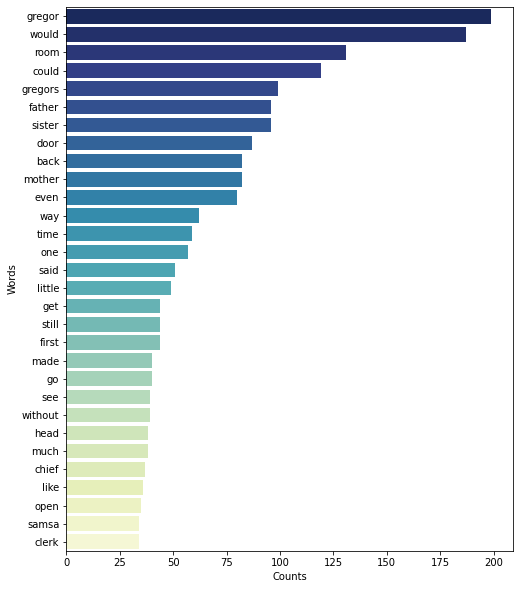

In [22]:
# Plot frequencies
words_plot_sw = pd.DataFrame(top_counts_sw, columns = ['Words', 'Counts'])
plt.figure(figsize=(8,10))
sns.barplot(y="Words", x="Counts", data=words_plot_sw, palette = "YlGnBu_r")

In [25]:
# Explore longer words, potentially as a signal for more "meaningful" words. Notice that some of these words
# were compound phrases and adjectives, such as "cucumberframe," which appears in the text as "cucumber-frame."
V = set(tokens)
long_words = [w for w in V if len(w) > 10]
print('Unique words over 10 characters:', len(long_words))
print('--------------------------------')
sorted(long_words)

Unique words over 10 characters: 150
--------------------------------


['accumulated',
 'accumulating',
 'accusations',
 'achievements',
 'allimportant',
 'announcement',
 'anticipation',
 'appreciated',
 'appreciation',
 'apprentices',
 'appropriate',
 'arrangement',
 'beautifully',
 'businessman',
 'celebrations',
 'chambermaids',
 'charlottenstrasse',
 'circumstances',
 'comfortable',
 'comfortably',
 'communicated',
 'communication',
 'compellingly',
 'complicated',
 'comprehension',
 'concentrated',
 'concentration',
 'conclusions',
 'confirmation',
 'congratulated',
 'connections',
 'consciousness',
 'conservatory',
 'considerate',
 'consideration',
 'considerations',
 'considering',
 'continually',
 'continuously',
 'conversation',
 'conversations',
 'destination',
 'deterioration',
 'determination',
 'differently',
 'disappeared',
 'disappointed',
 'disappointment',
 'disconcerted',
 'discourtesy',
 'dishevelled',
 'distinguish',
 'emergencies',
 'emphatically',
 'endearments',
 'enquiringly',
 'entertaining',
 'enthusiastic',
 'enunciating',
 'es

In [26]:
# Bigram analysis
bigram_list = list(nltk.bigrams(tokens))

# Display number of total bigrams and number of unique bigrams
print('Total bigrams across text: ' + str(len(bigram_list)))
print('Unique bigrams across text: ' + str(len(set(bigram_list))))

Total bigrams across text: 22009
Unique bigrams across text: 13090


In [0]:
# Plot word frequency
# Initialize a dictionary
dict_bigrams = {}

# Count number of times each word comes up in list of words
for key in bigram_list: 
    dict_bigrams[key] = dict_bigrams.get(key, 0) + 1

counts_bigrams = sorted(dict_bigrams.items(), key = lambda x: x[1], reverse = True)

In [0]:
# Most and least frequent word occurence
top_counts_bigrams = counts_bigrams[:30]
least_counts_bigrams = counts_bigrams[-30:]

In [29]:
print('top occuring bigrams:', top_counts_bigrams)
print('--------------------------')
print('least occuring bigrams:', least_counts_bigrams)

top occuring bigrams: [(('of', 'the'), 96), (('he', 'had'), 92), (('in', 'the'), 88), (('it', 'was'), 87), (('he', 'was'), 82), (('the', 'door'), 75), (('his', 'sister'), 68), (('to', 'the'), 64), (('his', 'father'), 60), (('he', 'could'), 58), (('on', 'the'), 57), (('had', 'been'), 54), (('that', 'he'), 53), (('as', 'he'), 45), (('at', 'the'), 43), (('of', 'his'), 43), (('as', 'if'), 43), (('in', 'his'), 42), (('to', 'be'), 41), (('from', 'the'), 41), (('he', 'would'), 39), (('his', 'mother'), 38), (('the', 'chief'), 37), (('the', 'room'), 37), (('and', 'the'), 36), (('she', 'had'), 36), (('if', 'he'), 35), (('into', 'the'), 35), (('they', 'had'), 35), (('out', 'of'), 34)]
--------------------------
least occuring bigrams: [(('and', 'beautiful'), 1), (('beautiful', 'young'), 1), (('lady', 'they'), 1), (('became', 'quieter'), 1), (('quieter', 'just'), 1), (('just', 'from'), 1), (('from', 'each'), 1), (('each', 'others'), 1), (('others', 'glance'), 1), (('glance', 'and'), 1), (('they', 

**Figure 3: Top 30 most frequently occurring bi-grams from text**

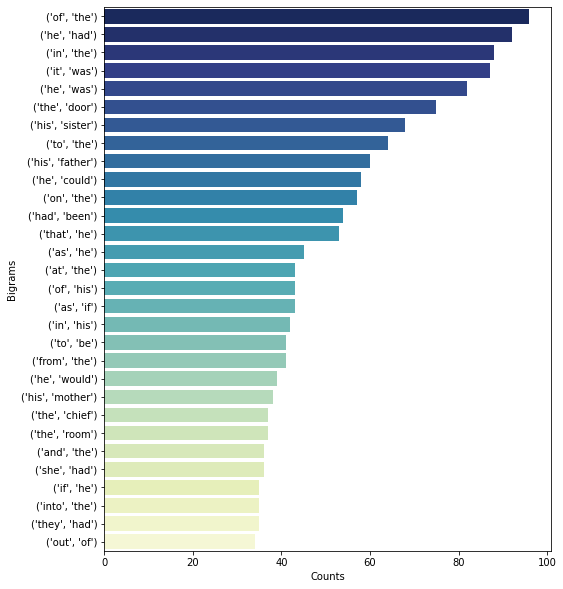

In [30]:
# Plot frequencies
bigrams_plot = pd.DataFrame(top_counts_bigrams, columns = ['Bigrams', 'Counts'])
plt.figure(figsize=(8,10))
sns.barplot(y="Bigrams", x="Counts", data=bigrams_plot, palette = "YlGnBu_r")

In [0]:
# # Find most frequently occurring bigrams (top 30)
# counter=Counter(bigram_list)
# # print(counter.most_common(30))
# print('Most common bigrams: ' + '\n' + str(counter.most_common(30)))

## 3. Save clean text as sequences and load document into memory
Sequence length is a key design decision: they must be long enough to properly allow models to learn the context and make reasonable predictions. The sequence length also defines the seed text length used to generate text sequences for model evaluation. A length of 50 is selected for this study, with sequences serving as inputs and training patterns to the various models. 

In [31]:
# Organize into sequences of tokens
length = 50 + 1
sequences = list()
for i in range(length, len(tokens)):
    # Select sequence of tokens
    seq = tokens[i-length:i]
    # Convert into a line
    line = ' '.join(seq)
    # Store
    sequences.append(line)
print('Total sequences: %d' % len(sequences))

Total sequences: 21959


In [0]:
# Save tokens to file, one dialog per line
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [0]:
# Save sequences to file
out_filename = 'meta_sequences.txt'
save_doc(sequences, out_filename)

In [0]:
# Define function to load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [0]:
# Load doc
in_filename = 'meta_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

## 4. Prepare data sequences for neural network input
The Tokenizer class in Keras is used to encode input sequences to integers, which the neural networks expect as input. The vocabulary size, defined by this encoding process, is defined as the vocabulary + 1 in length for feeding to the Embedding layer. After encoding, sequences are separated into input (X) and output (y) elements using array slicing. Output words are one hot encoded so the models in the study can predict the probability distribution for the next word.

In [0]:
# Integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

In [0]:
# Define vocabulary size
vocab_size = len(tokenizer.word_index) + 1

In [38]:
vocab_size

2614

In [0]:
# Separate sequences into input and output
sequences = array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

In [40]:
print('Total Sequences: %d' % len(sequences))

Total Sequences: 21959


## 5. Train language models

To train statistical models from the data, these experiments all employ an embedding layer to learn the representation of words. Parameterization of words as vectors in this manner, learned as part of the training process, enables words with a similar meaning to have a similar representation. LSTM RNNs then learn to predict words based on context. There is no test dataset: models are trained on the entire training dataset to learn the probability of each word in a sequence.

All models will employ the following hyperparameters for consistency and evaluation purposes:
* Loss function: categorical cross-entropy
* Optimizer: adam
* Batch size: 128
* Training epochs: 50
* Early stopping with patience of 5

### <i>Baseline experiment 1: LSTM RNN</i> 
This first neural network serves as a baseline, with a simple architecture and fewer memory cell units, to evaluate model performance on this text with a relatively spare neural network.
* 1 hidden layer
* 100 memory cell units
* Embedding vector space size 50

In [0]:
# Define model
model_1 = Sequential()
model_1.add(Embedding(vocab_size, 50, input_length=seq_length))
model_1.add(LSTM(100))
# model_1.add(LSTM(100))
model_1.add(Dense(100, activation='relu'))
model_1.add(Dense(vocab_size, activation='softmax'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            130700    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 2614)              264014    
Total params: 465,214
Trainable params: 465,214
Non-trainable params: 0
_________________________________________________________________


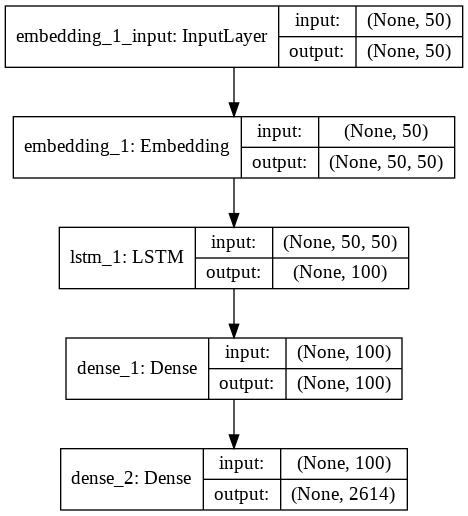

In [42]:
# Model summary
model_1.summary()
plot_model(model_1, to_file='figures/model_1.png', show_shapes=True)

In [0]:
# Compile model
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# Define the checkpoint
# filepath='results/exp1/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5'
filepath='results/exp1/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [45]:
# Fit the model
start_time = time.time()
history = model_1.fit(X, 
                      y, 
                      batch_size=128, 
                      epochs=50,
                      callbacks=callbacks_list)

elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
21959/21959 [==============================] - 27s 1ms/step - loss: 6.3925 - accuracy: 0.0475

Epoch 00001: loss improved from inf to 6.39253, saving model to results/exp1/best_model.hdf5
Epoch 2/50
21959/21959 [==============================] - 25s 1ms/step - loss: 5.9630 - accuracy: 0.0522

Epoch 00002: loss improved from 6.39253 to 5.96303, saving model to results/exp1/best_model.hdf5
Epoch 3/50
21959/21959 [==============================] - 25s 1ms/step - loss: 5.8669 - accuracy: 0.0532

Epoch 00003: loss improved from 5.96303 to 5.86691, saving model to results/exp1/best_model.hdf5
Epoch 4/50
21959/21959 [==============================] - 24s 1ms/step - loss: 5.7122 - accuracy: 0.0628

Epoch 00004: loss improved from 5.86691 to 5.71222, saving model to results/exp1/best_model.hdf5
Epoch 5/50
21959/21959 [==============================] - 24s 1ms/step - loss: 5.5729 - accuracy: 0.0735

Epoch 00005: loss improved from 5.71222 to 5.57290, saving model to results/exp1/best_

In [0]:
# Plot model performance

In [0]:
# history_dict = history.history
# history_dict.keys()

**Figure 4: Learning curves for Model 1**

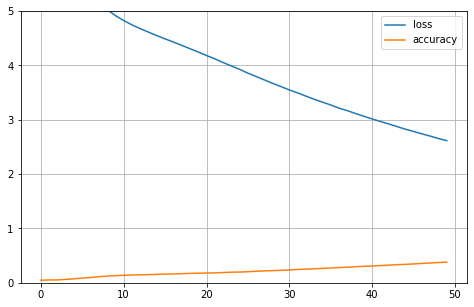

In [46]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5) # set the vertical range to [0-5]
plt.savefig('figures/learning_curves_model_1', tight_layout=False)
plt.show()

In [0]:
# Save the model to file
model_1.save('results/exp1/model_1.h5')
# Save the tokenizer
dump(tokenizer, open('meta_tokenizer.pkl', 'wb'))

In [0]:
# Prepare the language model

In [0]:
# Load cleaned text sequences
in_filename = 'meta_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

# Define sequence length
seq_length = len(lines[0].split()) - 1

In [50]:
# Load the model
model = load_model('results/exp1/model_1.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
# Load the tokenizer
tokenizer = load(open('meta_tokenizer.pkl', 'rb'))

In [0]:
# Generate text and evaluate

In [0]:
# Define function to generate sequence from language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word
        yhat = model.predict_classes(encoded, verbose=0)
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

In [0]:
# Select a seed text
seed_text = lines[randint(0,len(lines))]

In [55]:
# Generate new text
print('Seed text 1:', seed_text)
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 1:', generated)

Seed text 1: had become more obstinate and would always insist on staying longer at the table even though he regularly fell asleep and it was then harder than ever to persuade him to exchange the chair for his bed then however much mother and sister would importune him with little reproaches and warnings
----------------------------------
Generated text 1: he had been very fond of wearing them and smoking with the bed bend down in the morning and the chief clerk had fallen away from the door was opened a little frame for instance gregor whose whereabouts she had to do was take any of all the ones that


In [0]:
# Select a new seed text
seed_text = lines[randint(0,len(lines))]

In [57]:
# Generate new text
print('Seed text 2:', seed_text)
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 2:', generated)

Seed text 2: better of it gregor went and waited immediately by the door resolved either to bring the timorous visitor into the room in some way or at least to find out who it was but the door was opened no more that night and gregor waited in vain the previous morning while
----------------------------------
Generated text 2: the cleaner wanted to see it he was not able to cover it and wants to speak to the chief clerk had been permanently he had to be heard on the couch bitter and immobile but he had to do was take any of all the ones that the cleaner


In [0]:
# Select a new seed text
seed_text = lines[randint(0,len(lines))]

In [59]:
# Generate new text
print('Seed text 3:', seed_text)
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 3:', generated)

Seed text 3: a sign to him that he should withdraw he was immediately startled although he had been half asleep and he hurried back under the couch but he needed great selfcontrol to stay there even for the short time that his sister was in the room as eating so much food had
----------------------------------
Generated text 3: rounded out the contract the other side of the other room catching their breath he sallied out changed direction four closely to the window during the newspapers on the couch and watched to the repugnant conditions that prevail in this way that they were writing for the window and held


In [0]:
tf.keras.backend.clear_session()

### <i>Experiment 2: LSTM RNN </i>
This neural network differs from the baseline with additional memory cell units.
* 1 hidden layer
* 256 memory cell units
* Embedding vector space size 50

In [0]:
# Define model
model_2 = Sequential()
model_2.add(Embedding(vocab_size, 50, input_length=seq_length))
model_2.add(LSTM(256))
model_2.add(Dense(100, activation='relu'))
model_2.add(Dense(vocab_size, activation='softmax'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            130700    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               25700     
_________________________________________________________________
dense_2 (Dense)              (None, 2614)              264014    
Total params: 734,782
Trainable params: 734,782
Non-trainable params: 0
_________________________________________________________________


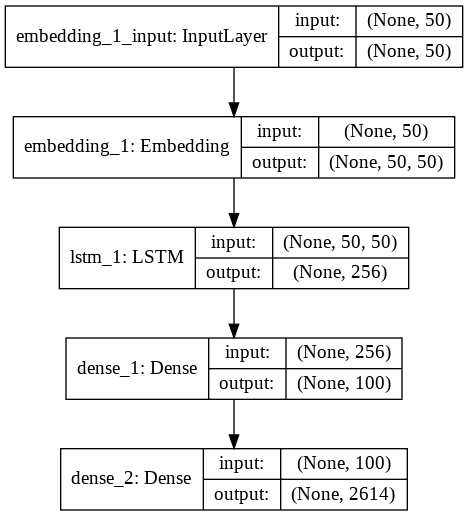

In [62]:
# Model summary
model_2.summary()
plot_model(model_2, to_file='figures/model_2.png', show_shapes=True)

In [0]:
# Compile model
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# Define the checkpoint
# filepath='results/exp2/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5'
filepath='results/exp2/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint,es]

In [65]:
# Fit the model
start_time = time.time()
history = model_2.fit(X, 
                      y, 
                      batch_size=128, 
                      epochs=50,
                      callbacks=callbacks_list)

elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
21959/21959 [==============================] - 26s 1ms/step - loss: 6.3315 - accuracy: 0.0488

Epoch 00001: loss improved from inf to 6.33150, saving model to results/exp2/best_model.hdf5
Epoch 2/50
21959/21959 [==============================] - 26s 1ms/step - loss: 5.9558 - accuracy: 0.0531

Epoch 00002: loss improved from 6.33150 to 5.95578, saving model to results/exp2/best_model.hdf5
Epoch 3/50
21959/21959 [==============================] - 26s 1ms/step - loss: 5.8303 - accuracy: 0.0587

Epoch 00003: loss improved from 5.95578 to 5.83034, saving model to results/exp2/best_model.hdf5
Epoch 4/50
21959/21959 [==============================] - 25s 1ms/step - loss: 5.6495 - accuracy: 0.0695

Epoch 00004: loss improved from 5.83034 to 5.64952, saving model to results/exp2/best_model.hdf5
Epoch 5/50
21959/21959 [==============================] - 26s 1ms/step - loss: 5.5091 - accuracy: 0.0822

Epoch 00005: loss improved from 5.64952 to 5.50912, saving model to results/exp2/best_

In [0]:
# Plot model performance

In [0]:
# history_dict = history.history
# history_dict.keys()

**Figure 5: Learning curves for Model 2**

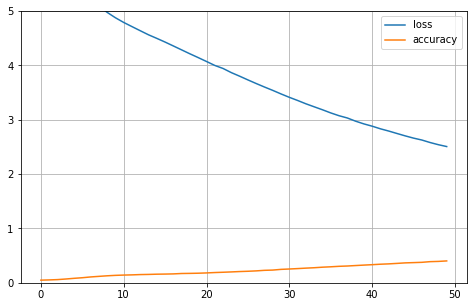

In [66]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5) # set the vertical range to [0-1]
plt.savefig('figures/learning_curves_model_2', tight_layout=False)
plt.show()

In [0]:
# Save the model to file
model_2.save('results/exp2/model_2.h5')
# save the tokenizer
# dump(tokenizer, open('meta_tokenizer.pkl', 'wb'))

In [0]:
# Prepare the language model

In [0]:
# Load cleaned text sequences
in_filename = 'meta_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

# Define sequence length
seq_length = len(lines[0].split()) - 1

In [69]:
# Load the model - use name from best model
model = load_model('results/exp2/model_2.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
# Load the tokenizer
tokenizer = load(open('meta_tokenizer.pkl', 'rb'))

In [0]:
# Generate text and evaluate

In [0]:
# Select a seed text
seed_text = lines[randint(0,len(lines))]

In [73]:
# Generate new text
print('Seed text 1:', seed_text)
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 1:', generated)

Seed text 1: that she would not look round and said albeit hurriedly and with a tremor in her voice come on lets go back in the living room for a while gregor could see what grete had in mind she wanted to take her mother somewhere safe and then chase him down from
----------------------------------
Generated text 1: the couch and stretched himself this was and lying peacefully later when he began to get rid of it thats his father was healthy but old more than usual and felt that he was not sleeping startled her he would have made him to get dressed and smiled the little


In [0]:
# Select a new seed text
seed_text = lines[randint(0,len(lines))]

In [75]:
# Generate new text
print('Seed text 2:', seed_text)
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 2:', generated)

Seed text 2: from going out to work and looking after gregor as she had done before was even more work for her but even so his mother ought certainly not to have taken her place gregor on the other hand ought not to be neglected now though the charwoman was here this elderly
----------------------------------
Generated text 2: widow with a dish piled high the middle of the door leading into the room gregor had been permanently he had been reduced to the chief clerk had left the chief clerk had left the chief clerk had left three took the door from the door was he really call


In [0]:
# Select a new seed text
seed_text = lines[randint(0,len(lines))]

In [77]:
# Generate new text
print('Seed text 3:', seed_text)
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 3:', generated)

Seed text 3: of air flew in from the street towards the stairway the curtains flew up the newspapers on the table fluttered and some of them were blown onto the floor nothing would stop gregors father as he drove him back making hissing noises at him like a wild man gregor had never
----------------------------------
Generated text 3: been accumulating called the door shut with his present state couldnt get out of the bed bend down onto the floor his father was healthy but old more than usual and felt how he was not at all throughout all this as he was not at all throughout all this


In [0]:
tf.keras.backend.clear_session()

### <i>Experiment 3: LSTM RNN </i>
This deeper neural network adds a hidden layer to determine impact on performance, training time, and ability to capture context of the document and generate meaningful text from seed text.
* 2 hidden layers
* 100 memory cell units
* Embedding vector space size 50

In [0]:
# Define model
model_3 = Sequential()
model_3.add(Embedding(vocab_size, 50, input_length=seq_length))
model_3.add(LSTM(100, return_sequences=True))
model_3.add(LSTM(100))
model_3.add(Dense(100, activation='relu'))
model_3.add(Dense(vocab_size, activation='softmax'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            130700    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 100)           60400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 2614)              264014    
Total params: 545,614
Trainable params: 545,614
Non-trainable params: 0
_________________________________________________________________


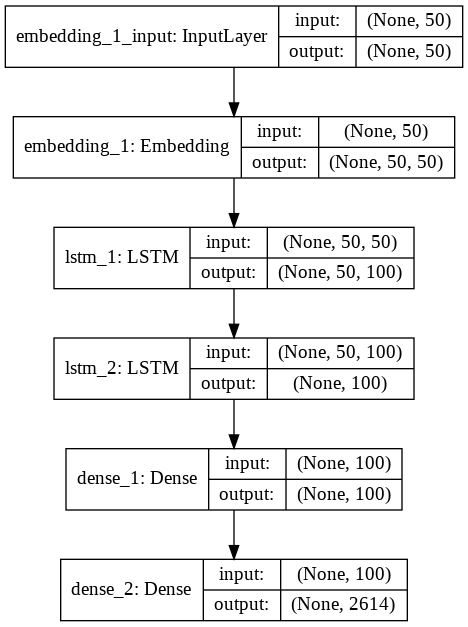

In [80]:
# Model summary
model_3.summary()
plot_model(model_3, to_file='figures/model_3.png', show_shapes=True)

In [0]:
# Compile model
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# Define the checkpoint
filepath='results/exp3/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [83]:
# Fit the model
start_time = time.time()
history = model_3.fit(X, 
                      y, 
                      batch_size=128, 
                      epochs=50,
                      callbacks=callbacks_list)

elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
21959/21959 [==============================] - 47s 2ms/step - loss: 6.3910 - accuracy: 0.0488

Epoch 00001: loss improved from inf to 6.39100, saving model to results/exp3/best_model.hdf5
Epoch 2/50
21959/21959 [==============================] - 46s 2ms/step - loss: 6.0346 - accuracy: 0.0522

Epoch 00002: loss improved from 6.39100 to 6.03456, saving model to results/exp3/best_model.hdf5
Epoch 3/50
21959/21959 [==============================] - 45s 2ms/step - loss: 5.9149 - accuracy: 0.0525

Epoch 00003: loss improved from 6.03456 to 5.91492, saving model to results/exp3/best_model.hdf5
Epoch 4/50
21959/21959 [==============================] - 45s 2ms/step - loss: 5.7715 - accuracy: 0.0591

Epoch 00004: loss improved from 5.91492 to 5.77150, saving model to results/exp3/best_model.hdf5
Epoch 5/50
21959/21959 [==============================] - 45s 2ms/step - loss: 5.6490 - accuracy: 0.0686

Epoch 00005: loss improved from 5.77150 to 5.64901, saving model to results/exp3/best_

In [0]:
 # Plot model performance

In [0]:
# history_dict = history.history
# history_dict.keys()

**Figure 6: Learning curves for Model 3**

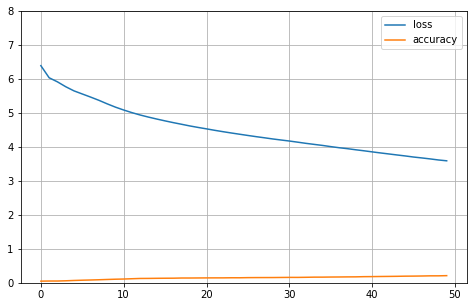

In [84]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 8) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_3", tight_layout=False)
plt.show()

In [0]:
# Save the model to file
model_3.save('results/exp3/model_3.h5')
# save the tokenizer
# dump(tokenizer, open('meta_tokenizer.pkl', 'wb'))

In [0]:
# Prepare the language model

In [0]:
# Load cleaned text sequences
in_filename = 'meta_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

# Define sequence length
seq_length = len(lines[0].split()) - 1

In [88]:
# Load the model - use name from best model
model = load_model('results/exp3/model_3.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
# Load the tokenizer
tokenizer = load(open('meta_tokenizer.pkl', 'rb'))

In [0]:
# Generate text and evaluate

In [0]:
# Select a seed text
seed_text = lines[randint(0,len(lines))]

In [92]:
# Generate new text
print('Seed text 1:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 1:', generated)

Seed text 1: happening without even giving the impression of a chase as everything went so slowly gregor remained all this time on the floor largely because he feared his father might see it as especially provoking if he fled onto the wall or ceiling whatever he did gregor had to admit that he

----------------------------------
Generated text 1: was not enough to get it he was not enough to get it he was not enough to get it he was not enough to get it he was not enough to get it he was not enough to get it he was not enough to get it he was


In [0]:
# Select a new seed text
seed_text = lines[randint(0,len(lines))]

In [94]:
# Generate new text
print('Seed text 2:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 2:', generated)

Seed text 2: still be heard as if they had wanted to show gregor that you need teeth in order to eat and it was not possible to perform anything with jaws that are toothless however nice they might be id like to eat something said gregor anxiously but not anything like theyre eating

----------------------------------
Generated text 2: that he had been forgotten up with the table and not the time of a way in his room and had been more than usual himself the harder which was not the door and had been more than usual himself the harder which was not the door and had been


In [0]:
# Select a new seed text
seed_text = lines[randint(0,len(lines))]

In [96]:
# Generate new text
print('Seed text 3:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 3:', generated)

Seed text 3: into new positions alright well go then he said and looked up at mr samsa as if he had been suddenly overcome with humility and wanted permission again from mr samsa for his decision mr samsa merely opened his eyes wide and briefly nodded to him several times at that and

----------------------------------
Generated text 3: as he could not be seen that he was not enough to get it he was not enough to get it he was not enough to get it he was not enough to get it he was not enough to get it he was not enough to get it he


In [0]:
tf.keras.backend.clear_session()

### <i>Experiment 4: LSTM RNN with 2 hidden layers and additional memory cell units</i>
This deeper neural network adds memory cell units to the architecture of the model from Experiment 3 to determine impact on performance, training time, and ability to capture context of the document and generate meaningful text from seed text.
* 2 hidden layers
* 256 memory cell units
* Embedding vector space size 50

In [0]:
# Define model
model_4 = Sequential()
model_4.add(Embedding(vocab_size, 50, input_length=seq_length))
model_4.add(LSTM(256, return_sequences=True))
model_4.add(LSTM(256))
model_4.add(Dense(256, activation='relu'))
model_4.add(Dense(vocab_size, activation='softmax'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            130700    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 256)           314368    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 2614)              671798    
Total params: 1,707,970
Trainable params: 1,707,970
Non-trainable params: 0
_________________________________________________________________


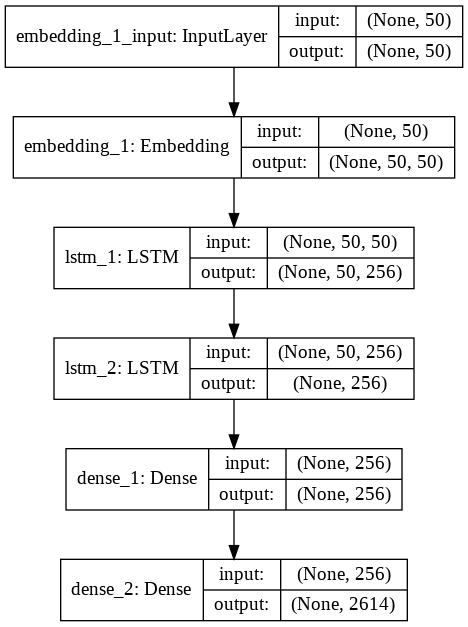

In [99]:
# Model summary
model_4.summary()
plot_model(model_4, to_file='figures/model_4.png', show_shapes=True)

In [0]:
# Compile model
model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# Define the checkpoint
filepath='results/exp4/est_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [102]:
# Fit the model
start_time = time.time()
history = model_4.fit(X, 
                      y, 
                      batch_size=128, 
                      epochs=50,
                      callbacks=callbacks_list)

elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
21959/21959 [==============================] - 51s 2ms/step - loss: 6.3410 - accuracy: 0.0492

Epoch 00001: loss improved from inf to 6.34101, saving model to results/exp4/est_model.hdf5
Epoch 2/50
21959/21959 [==============================] - 49s 2ms/step - loss: 5.9834 - accuracy: 0.0520

Epoch 00002: loss improved from 6.34101 to 5.98335, saving model to results/exp4/est_model.hdf5
Epoch 3/50
21959/21959 [==============================] - 50s 2ms/step - loss: 5.8086 - accuracy: 0.0567

Epoch 00003: loss improved from 5.98335 to 5.80857, saving model to results/exp4/est_model.hdf5
Epoch 4/50
21959/21959 [==============================] - 49s 2ms/step - loss: 5.6328 - accuracy: 0.0696

Epoch 00004: loss improved from 5.80857 to 5.63282, saving model to results/exp4/est_model.hdf5
Epoch 5/50
21959/21959 [==============================] - 49s 2ms/step - loss: 5.4972 - accuracy: 0.0734

Epoch 00005: loss improved from 5.63282 to 5.49724, saving model to results/exp4/est_model

In [0]:
# Plot model performance

In [0]:
# history_dict = history.history
# history_dict.keys()

**Figure 7: Learning curves for Model 4**

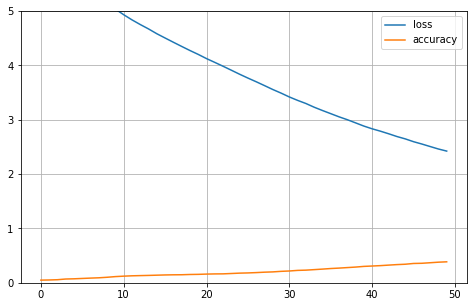

In [104]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5) # set the vertical range to [0-1]
plt.savefig('figures/learning_curves_model_4', tight_layout=False)
plt.show()

In [0]:
# Save the model to file
model_4.save('results/exp4/model_4.h5')
# save the tokenizer
# dump(tokenizer, open('meta_tokenizer.pkl', 'wb'))

In [0]:
# Prepare the language model

In [0]:
# Load cleaned text sequences
in_filename = 'meta_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

# Define sequence length
seq_length = len(lines[0].split()) - 1

In [108]:
# Load the model - use name from best model
model = load_model('results/exp4/model_4.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
# Load the tokenizer
tokenizer = load(open('meta_tokenizer.pkl', 'rb'))

In [0]:
# Generate text and evaluate

In [0]:
# Select a seed text
seed_text = lines[randint(0,len(lines))]

In [112]:
# Generate new text
print('Seed text 1:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 1:', generated)

Seed text 1: the most important meal of the day and he would stretch it out for several hours as he sat reading a number of different newspapers on the wall exactly opposite there was photograph of gregor when he was a lieutenant in the army his sword in his hand and a carefree

----------------------------------
Generated text 1: smile on his voice and put himself back in the bed bend down with the load that was already until they were worried of the table the way he had been working so now they had been in home and the three gentlemen had already rubbing the room he did


In [0]:
# Select a new seed text
seed_text = lines[randint(0,len(lines))]

In [114]:
# Generate new text
print('Seed text 2:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 2:', generated)

Seed text 2: too slow for him to think of any other way of saving himself than running he almost forgot that the walls were there for him to use although here they were concealed behind carefully carved furniture full of notches and protrusions then right beside him lightly tossed something flew down and

----------------------------------
Generated text 2: rolled anxiously threw himself out of the flat thatll be seen for lying in his chair and the chief clerk had certainly come out to the door in his voice probably could take running about with the eight time man seven oclock already he would call to him about the


In [0]:
# Select a new seed text
seed_text = lines[randint(0,len(lines))]

In [116]:
# Generate new text
print('Seed text 3:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 3:', generated)

Seed text 3: off some of her clothes after she had fainted to make it easier for her to breathe she ran to his father her skirts unfastened and sliding one after another to the ground stumbling over the skirts she pushed herself to his father her arms around him uniting herself with him

----------------------------------
Generated text 3: in unhappy silence about the covers in his room and flew up in the bed and into his observant sister would break pressed today and mother aware him plenty of time to use to regret it he would add so that she would lift to make his own free emerged


In [0]:
tf.keras.backend.clear_session()

### <i>Experiment 5: LSTM RNN with larger embedding vector space</i>
This experiment takes the best model from Experiment 4, with 2 hidden layers and 256 memory cell units, and tests the increased embedding vector space on performance and interpretability.
* 1 hidden layer
* 256 memory cell units
* Embedding vector space size 100

In [0]:
# Define model
model_5 = Sequential()
model_5.add(Embedding(vocab_size, 100, input_length=seq_length))
model_5.add(LSTM(256))
model_5.add(Dense(256, activation='relu'))
model_5.add(Dense(vocab_size, activation='softmax'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           261400    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 2614)              671798    
Total params: 1,364,558
Trainable params: 1,364,558
Non-trainable params: 0
_________________________________________________________________


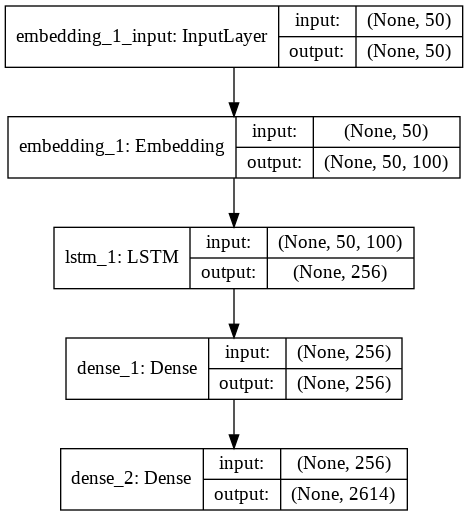

In [125]:
# Model summary
model_5.summary()
plot_model(model_5, to_file='figures/model_5.png', show_shapes=True)

In [0]:
# Compile model
model_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# Define the checkpoint
filepath='results/exp5/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
callbacks_list = [checkpoint, es]

In [128]:
# Fit the model
start_time = time.time()
history = model_5.fit(X, 
                      y, 
                      batch_size=128, 
                      epochs=50,
                      callbacks=callbacks_list)

elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
21959/21959 [==============================] - 26s 1ms/step - loss: 6.3038 - accuracy: 0.0500

Epoch 00001: loss improved from inf to 6.30377, saving model to results/exp5/best_model.hdf5
Epoch 2/50
21959/21959 [==============================] - 26s 1ms/step - loss: 5.9308 - accuracy: 0.0532

Epoch 00002: loss improved from 6.30377 to 5.93085, saving model to results/exp5/best_model.hdf5
Epoch 3/50
21959/21959 [==============================] - 27s 1ms/step - loss: 5.7228 - accuracy: 0.0695

Epoch 00003: loss improved from 5.93085 to 5.72280, saving model to results/exp5/best_model.hdf5
Epoch 4/50
21959/21959 [==============================] - 26s 1ms/step - loss: 5.4354 - accuracy: 0.0976

Epoch 00004: loss improved from 5.72280 to 5.43541, saving model to results/exp5/best_model.hdf5
Epoch 5/50
21959/21959 [==============================] - 26s 1ms/step - loss: 5.1862 - accuracy: 0.1154

Epoch 00005: loss improved from 5.43541 to 5.18624, saving model to results/exp5/best_

In [0]:
# Plot model performance

In [0]:
# history_dict = history.history
# history_dict.keys()

**Figure 8: Learning curves for Model 5**

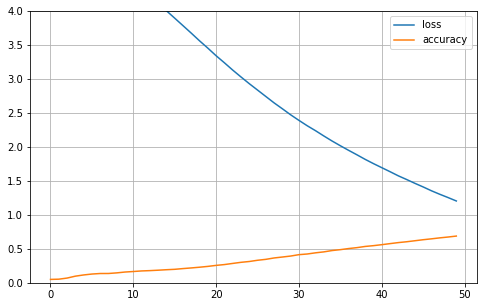

In [129]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 4) # set the vertical range to [0-1]
plt.savefig('figures/learning_curves_model_5', tight_layout=False)
plt.show()

In [0]:
# Save the model to file
model_5.save('results/exp5/model_5.h5')
# save the tokenizer
# dump(tokenizer, open('meta_tokenizer.pkl', 'wb'))

In [0]:
# Prepare the language model

In [0]:
# Load cleaned text sequences
in_filename = 'meta_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

# Define sequence length
seq_length = len(lines[0].split()) - 1

In [133]:
# Load the model - use name from best model
model = load_model('results/exp5/model_5.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
# Load the tokenizer
tokenizer = load(open('meta_tokenizer.pkl', 'rb'))

In [0]:
# Generate text and evaluate

In [0]:
# Select a seed text
seed_text = lines[randint(0,len(lines))]

In [137]:
# Generate new text
print('Seed text 1:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 1:', generated)

Seed text 1: entertain himself he got into the habit of crawling up and down the walls and ceiling he was especially fond of hanging from the ceiling it was quite different from lying on the floor he could breathe more freely his body had a light swing to it and up there relaxed

----------------------------------
Generated text 1: and almost happy it might happen to the edges of it a cashier from a hat shop for whom his attention had been serious but too slow and almost happy it might happen to the edges of it a cashier from a hat shop for whom his attention had been


In [0]:
# select a new seed text
seed_text = lines[randint(0,len(lines))]

In [139]:
# generate new text
print('Seed text 2:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 2:', generated)

Seed text 2: he realised what it actually was that had drawn him over to it it was the smell of something to eat by the door there was a dish filled with sweetened milk with little pieces of white bread floating in it he was so pleased he almost laughed as he was

----------------------------------
Generated text 2: covered and had his sister noticed it and he finally managed to get dressed and most of all playing it was nearly a miracle if only had been the chest of drawers groaning out of the bed than his sister noticed it hit a heavy fur muff that covered the


In [0]:
# select a new seed text
seed_text = lines[randint(0,len(lines))]

In [141]:
# generate new text
print('Seed text 3:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 3:', generated)

Seed text 3: hand the pillows and covers on the beds flew up and were put into order and she had already finished making the beds and slipped out again before the three gentlemen had reached the room gregors father seemed so obsessed with what he was doing that he forgot all the respect

----------------------------------
Generated text 3: he owed to his tenants he urged them and pressed them until when he had been yearning for he had after all often failed to get himself upright more through the lower part of his body might be seen for the effort to muster all the strength he could gather


In [0]:
tf.keras.backend.clear_session()

### <i>Experiment 6: Bidirectional LSTM with 1 HL and 50% dropout</i>
This final experiment employs a Bidirectional LSTM and 50 percent dropout to evaluate WHAT.
* 1 hidden layer
* 256 memory cell units
* Embedding vector space size 50

In [0]:
# Define model
model_6 = Sequential()
model_6.add(Embedding(vocab_size, 50, input_length=seq_length))
model_6.add(Bidirectional(LSTM(256)))
model_6.add(Dropout(0.5))
# model_6.add(LSTM(256))
# model_6.add(Dense(256, activation='relu'))
model_6.add(Dense(vocab_size, activation='softmax'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            130700    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               628736    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2614)              1340982   
Total params: 2,100,418
Trainable params: 2,100,418
Non-trainable params: 0
_________________________________________________________________


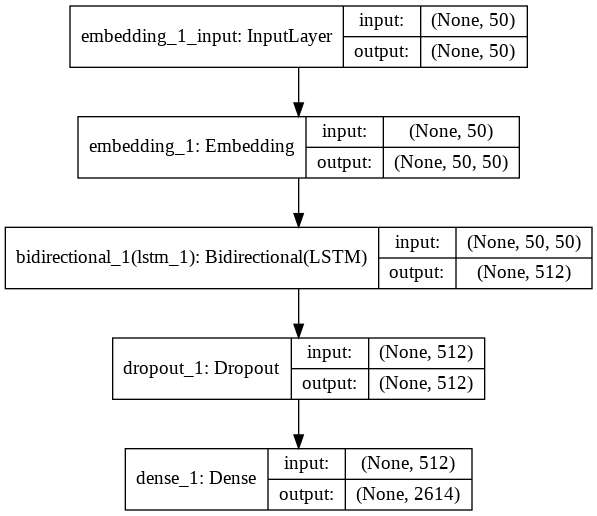

In [148]:
# Model summary
model_6.summary()
plot_model(model_6, to_file='figures/model_6.png', show_shapes=True)

In [0]:
# Compile model
model_6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# Define the checkpoint
filepath='results/exp6/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [151]:
# Fit the model
start_time = time.time()
history = model_6.fit(X, 
                      y, 
                      batch_size=128, 
                      epochs=50,
                      callbacks=callbacks_list)

elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
21959/21959 [==============================] - 51s 2ms/step - loss: 6.3050 - accuracy: 0.0490

Epoch 00001: loss improved from inf to 6.30498, saving model to results/exp6/best_model.hdf5
Epoch 2/50
21959/21959 [==============================] - 50s 2ms/step - loss: 5.9844 - accuracy: 0.0526

Epoch 00002: loss improved from 6.30498 to 5.98439, saving model to results/exp6/best_model.hdf5
Epoch 3/50
21959/21959 [==============================] - 50s 2ms/step - loss: 5.8006 - accuracy: 0.0647

Epoch 00003: loss improved from 5.98439 to 5.80064, saving model to results/exp6/best_model.hdf5
Epoch 4/50
21959/21959 [==============================] - 50s 2ms/step - loss: 5.5905 - accuracy: 0.0824

Epoch 00004: loss improved from 5.80064 to 5.59054, saving model to results/exp6/best_model.hdf5
Epoch 5/50
21959/21959 [==============================] - 51s 2ms/step - loss: 5.3841 - accuracy: 0.1029

Epoch 00005: loss improved from 5.59054 to 5.38412, saving model to results/exp6/best_

In [0]:
# Plot model performance

In [0]:
# history_dict = history.history
# history_dict.keys()

**Figure 9: Learning curves for Model 6**

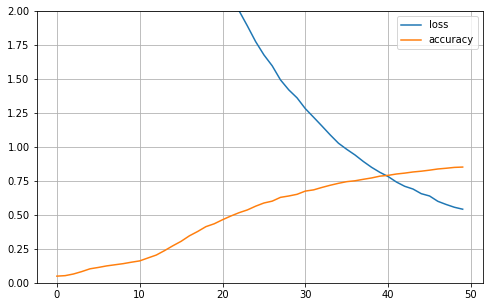

In [152]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.savefig('figures/learning_curves_model_6', tight_layout=False)
plt.show()

In [0]:
# Save the model to file
model_6.save('results/exp6/model_6.h5')
# save the tokenizer
# dump(tokenizer, open('meta_tokenizer.pkl', 'wb'))

In [0]:
# Prepare the language model

In [0]:
# Load cleaned text sequences
in_filename = 'meta_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

# Define sequence length
seq_length = len(lines[0].split()) - 1

In [156]:
# Load the model - use name from best model
model = load_model('results/exp6/model_6.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
# Load the tokenizer
tokenizer = load(open('meta_tokenizer.pkl', 'rb'))

In [0]:
# Generate text and evaluate

In [0]:
# Select a seed text
seed_text = lines[randint(0,len(lines))]

In [160]:
# Generate new text
print('Seed text 1:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 1:', generated)

Seed text 1: gregor against their expectations was still at home and soon his father came knocking at one of the side doors gently but with his fist gregor gregor he called whats wrong and after a short while he called again with a warning deepness in his voice gregor gregor at the other

----------------------------------
Generated text 1: side door his sister came plaintively gregor arent you well do you need anything gregor answered to both sides im ready now making an effort to remove all the strangeness from his voice by enunciating very carefully and putting long pauses between each individual word his father went back to


In [0]:
# select a new seed text
seed_text = lines[randint(0,len(lines))]

In [162]:
# generate new text
print('Seed text 2:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 2:', generated)

Seed text 2: but gretes words had made her mother quite worried she stepped to one side saw the enormous brown patch against the flowers of the wallpaper and before she even realised it was gregor that she saw screamed oh god oh god arms outstretched she fell onto the couch as if she

----------------------------------
Generated text 2: had given up everything and stayed there immobile gregor shouted his sister glowering at him and shaking her fist that was the first word she had spoken to him directly since his transformation she ran into the other room to fetch some kind of smelling salts to bring her mother


In [0]:
# select a new seed text
seed_text = lines[randint(0,len(lines))]

In [164]:
# generate new text
print('Seed text 3:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 3:', generated)

Seed text 3: to mean that something bad had happened that he was responsible for some act of violence that meant gregor would now have to try to calm his father as he did not have the time to explain things to him even if that had been possible so he fled to the

----------------------------------
Generated text 3: door of his room and pressed himself against it so that his father when he came in from the hall could see straight away that gregor had the best intentions and would go back into his room without delay that it would not be necessary to drive him back but


In [0]:
tf.keras.backend.clear_session()